# Тестовое задание

 Исполнитель: Владислав Кудюров

 Задача 1:


*   Проведите аналитику полученных данных

*   Подготовьте данные для регрессионной модели
*   Обучите регрессионную модель и осуществите прогноз на последний месяц для поля SALES

*   Оцените качество модели с помощью функции metric









In [81]:
# Загружаем библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from pylab import rcParams
from mlxtend.plotting import scatterplotmatrix

import os
import warnings
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, GridSearchCV

rcParams['figure.figsize'] = 20, 10
sns.set()
warnings.filterwarnings("ignore")
%matplotlib inline

In [82]:
# подключаем гугл драйв диск для загрузки файлов
from google.colab import drive 
drive.mount('/content/drive')

# Указываем путь к данным
PATH = '/content/drive/My Drive/datasets/test_magnit/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Проведем аналитику полученных данных

In [83]:
# Загружаем данные 
df = pd.read_csv(PATH + 'data_regression_for_task.csv')
df.index += 1
display(df)

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
1,2017,4,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.0,0.0
2,2017,4,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.0,0.0
3,2017,4,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.0,0.0
4,2017,4,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.0,0.0
5,2017,4,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.0,0.0
...,...,...,...,...,...,...,...,...
128351,2018,2,ANHEUSER BUSCH INC,9997,HOEGAARDEN 4/6NR - 12OZ,BEER,66460.0,212.0
128352,2018,2,COASTAL BREWING COMPANY LLC,99970,DOMINION OAK BARREL STOUT 4/6 NR - 12OZ,BEER,9080.0,35.0
128353,2018,2,BOSTON BEER CORPORATION,99988,SAM ADAMS COLD SNAP 1/6 KG,KEGS,0.0,32.0
128354,2018,2,NaN,BC,BEER CREDIT,REF,0.0,-35.0


In [84]:
# Выведем информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128355 entries, 1 to 128355
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   YEAR           128355 non-null  int64  
 1   MONTH          128355 non-null  int64  
 2   CONTRAGENT     128331 non-null  object 
 3   ARTICLE_CODE   128355 non-null  object 
 4   ARTICLE_NAME   128355 non-null  object 
 5   ARTICLE_GROUP  128354 non-null  object 
 6   SALES          128355 non-null  float64
 7   STORE_SALES    128355 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 7.8+ MB


In [85]:
# Функция для вычисления процентного списка пропущенных данных
def get_persent(fn):
  try:
    for col in fn.columns:
      pct_missing = np.mean(fn[col].isnull())
      print('{} - {}%'.format(col, round(pct_missing*100, 3)))
  except ValueError:
    print('Error DataFrame')

# Метрика для оценки модели
def metric(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_pred) * 100


In [86]:
# Oтображения сводной статистики числовых переменных
print(f'Сводная статистика числовых переменных:\n {df.describe().T}')

# Проверка датасета на отсутствие данных 
print(f'\nСумма пропущенных значений в переменных:\n{df.isna().sum()}')
print(f'\nПроцент пропущенных данных:')
get_persent(df)

Сводная статистика числовых переменных:
                 count         mean           std  ...     50%     75%         max
YEAR         128355.0  2017.206030      0.404454  ...  2017.0  2017.0     2018.00
MONTH        128355.0     7.079303      3.645826  ...     8.0    10.0       12.00
SALES        128355.0  6563.037435  28924.944352  ...   330.0  3250.0  1616600.00
STORE_SALES  128355.0    22.624213    239.693277  ...     1.0     4.0    16271.75

[4 rows x 8 columns]

Сумма пропущенных значений в переменных:
YEAR              0
MONTH             0
CONTRAGENT       24
ARTICLE_CODE      0
ARTICLE_NAME      0
ARTICLE_GROUP     1
SALES             0
STORE_SALES       0
dtype: int64

Процент пропущенных данных:
YEAR - 0.0%
MONTH - 0.0%
CONTRAGENT - 0.019%
ARTICLE_CODE - 0.0%
ARTICLE_NAME - 0.0%
ARTICLE_GROUP - 0.001%
SALES - 0.0%
STORE_SALES - 0.0%


# Подготовка данных для регрессионной модели

In [87]:
# Посмотрим, насколько каждая независимая переменная соотносится с этой зависимой переменной
data_matrix = df.corr()
data_matrix["SALES"].sort_values(ascending=False)

SALES          1.000000
STORE_SALES    0.459783
MONTH          0.028801
YEAR          -0.013295
Name: SALES, dtype: float64

In [88]:
# Удалим ненужные столбцы
data = df.drop(['CONTRAGENT', 'ARTICLE_CODE', 'YEAR', 'ARTICLE_NAME'], axis=1)
data.head(10)

,MONTH,ARTICLE_GROUP,SALES,STORE_SALES
1,4,WINE,0.0,0.0
2,4,WINE,0.0,0.0
3,4,LIQUOR,0.0,0.0
4,4,LIQUOR,0.0,0.0
5,4,WINE,0.0,0.0
6,4,WINE,0.0,0.0
7,4,WINE,0.0,0.0
8,4,LIQUOR,0.0,0.0
9,4,WINE,0.0,0.0
10,4,WINE,0.0,0.0


In [89]:
# Распарсим категориальную переменную
print(f'Категориальная переменная:\n{data.ARTICLE_GROUP.value_counts(normalize=True)}')
data = pd.get_dummies(data, columns=['ARTICLE_GROUP'], drop_first=True)
data.head(10)

Категориальная переменная:
WINE            0.616085
LIQUOR          0.221240
BEER            0.127966
KEGS            0.028343
NON-ALCOHOL     0.004893
STR_SUPPLIES    0.000826
REF             0.000397
DUNNAGE         0.000249
Name: ARTICLE_GROUP, dtype: float64


,MONTH,SALES,STORE_SALES,ARTICLE_GROUP_DUNNAGE,ARTICLE_GROUP_KEGS,ARTICLE_GROUP_LIQUOR,ARTICLE_GROUP_NON-ALCOHOL,ARTICLE_GROUP_REF,ARTICLE_GROUP_STR_SUPPLIES,ARTICLE_GROUP_WINE
1,4,0.0,0.0,0,0,0,0,0,0,1
2,4,0.0,0.0,0,0,0,0,0,0,1
3,4,0.0,0.0,0,0,1,0,0,0,0
4,4,0.0,0.0,0,0,1,0,0,0,0
5,4,0.0,0.0,0,0,0,0,0,0,1
6,4,0.0,0.0,0,0,0,0,0,0,1
7,4,0.0,0.0,0,0,0,0,0,0,1
8,4,0.0,0.0,0,0,1,0,0,0,0
9,4,0.0,0.0,0,0,0,0,0,0,1
10,4,0.0,0.0,0,0,0,0,0,0,1


In [90]:
# Проверка датасета на отсутствие данных 
print(f'Сумма пропущенных значений в переменных:\n{data.isna().sum()}')

Сумма пропущенных значений в переменных:
MONTH                         0
SALES                         0
STORE_SALES                   0
ARTICLE_GROUP_DUNNAGE         0
ARTICLE_GROUP_KEGS            0
ARTICLE_GROUP_LIQUOR          0
ARTICLE_GROUP_NON-ALCOHOL     0
ARTICLE_GROUP_REF             0
ARTICLE_GROUP_STR_SUPPLIES    0
ARTICLE_GROUP_WINE            0
dtype: int64


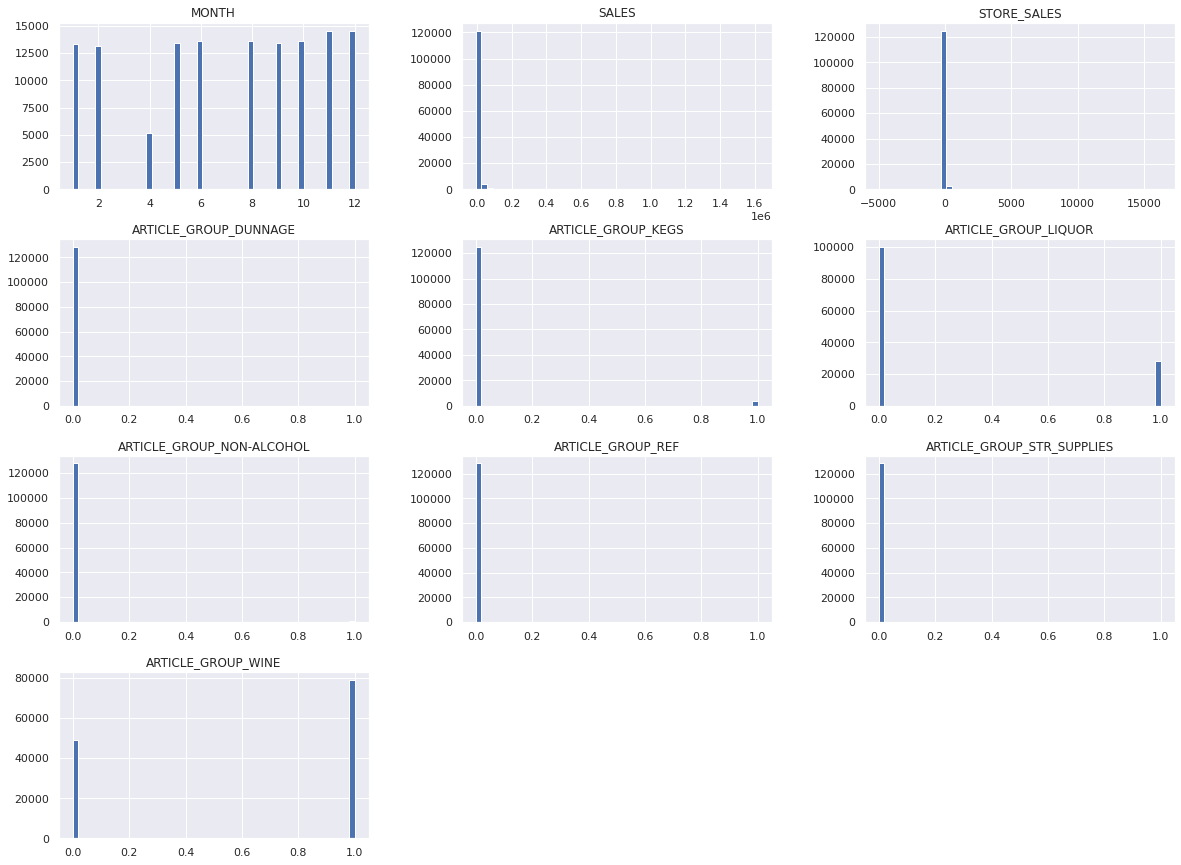

In [97]:
# Строим гистограмму для каждой числовой переменной, чтоб узнать тип данных
data.hist(bins=50, figsize=(20,15))
sns.set(style='whitegrid', rc={"grid.linewidth": 0.1})
plt.savefig("attribute_histogram_plots")
plt.show()

In [98]:
# Получим Х и Y
data['MONTH'].astype('float')
X = data.drop('SALES', axis=1)
Y = data['SALES']
Y = np.array(Y).reshape(-1,1)

print(X.shape)
print(Y.shape)

(128355, 9)
(128355, 1)


In [106]:
# подготовим наши данные, разобъем всю выборку на три части: обучающую, валидационную и тестовую.
X_train, X_test, y_train, y_test= train_test_split(X, Y, random_state=0, test_size=0.3)
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')


X_train: (89848, 9), y_train: (89848, 1)
X_test: (38507, 9), y_test: (38507, 1)


# Обучим регрессионную модель и осуществите прогноз на последний месяц для поля SALES

In [107]:
# Создадим Pipeline и хэш-таблицу с параметрами для подбора модели с помощью решетчатого поиска

pipe = Pipeline([('scaler', MinMaxScaler()), 
                 ('model', MultiOutputRegressor(LinearRegression()))])
param_grid = [{'model': [MultiOutputRegressor(LinearRegression())]}, 
               {'model': [MultiOutputRegressor(Ridge())]}, 
               {'model': [MultiOutputRegressor(Lasso())]}, 
               {'model': [MultiOutputRegressor(SGDRegressor())]}, 
               {'model': [MultiOutputRegressor(SVR(kernel='poly'))]}, 
               {'model': [MultiOutputRegressor(LinearSVR())]}, 
               {'model': [MultiOutputRegressor(RandomForestRegressor())]}, 
               {'model': [MultiOutputRegressor(XGBRegressor(objective ='reg:squarederror'))]}]

In [108]:
# Далее разобъем наши данные на фолды, для более корректной кросс-валидации, 
# так как у нас много моделей, а так же что тестовый набор составляет примерно 1/3 от обучающего, то выберем парметр cv=3

kfold = KFold(n_splits=3)

# Приступим к подбору модели и оптимальных параметров
#Модель для rougher
grid_model= GridSearchCV(pipe, param_grid=param_grid, cv=kfold, n_jobs=-1)

In [109]:
%%time

# Обучим сначала модель для этапа rougher
grid_model.fit(X_train, y_train)

CPU times: user 3.12 s, sys: 193 ms, total: 3.31 s
Wall time: 4min 8s


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('model',
                                        MultiOutputRegressor(estimator=LinearRegression(copy_X=True,
                                                                                        fit_intercept=True,
                                                                                        n_jobs=None,
                                                                                        normalize=False),
                                                             n_jobs=None))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             p...
               

In [110]:
# Посмотрим, какая модель и с какими параметрами оказалась лучшей
grid_model.best_params_

{'model': MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=1, gamma=0,
                                             importance_type='gain',
                                             learning_rate=0.1, max_delta_step=0,
                                             max_depth=3, min_child_weight=1,
                                             missing=None, n_estimators=100,
                                             n_jobs=1, nthread=None,
                                             objective='reg:squarederror',
                                             random_state=0, reg_alpha=0,
                                             reg_lambda=1, scale_pos_weight=1,
                                             seed=None, silent=None, subsample=1,
                      

# Оцените качество модели с помощью функции metric

In [111]:
#Получим предсказания
y_pred_array = pd.DataFrame(grid_model.predict(X_test))
y_pred_array

,0
0,934.499695
1,6464.163574
2,1384.623535
3,2344.855225
4,6575.760254
...,...
38502,17423.341797
38503,1962.756470
38504,15713.921875
38505,6464.163574


In [114]:
# Оценим модель метрикой
get_metric_score = metric(y_test, y_pred_array)
get_metric_score

0    100.515109
dtype: float64

In [128]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam


In [125]:
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

X_train: (89848, 9), y_train: (89848, 1)
X_test: (38507, 9), y_test: (38507, 1)


In [126]:
# В качестве нормализации данных используем готовую библиотеку 
yScaler = StandardScaler()

# Скармливаем объекту двумерный вектор
yScaler.fit(y_train.reshape(-1, 1))

# Нормализуем по нормальному распределению
y_trainScaled = yScaler.transform(y_train.reshape(-1, 1))

print(y_trainScaled.shape)
print(y_train[1])
print(y_trainScaled[1])

(89848, 1)
[80.]
[-0.21922881]


In [135]:
# Обучаем модель полученными данными
model = Sequential()
model.add(BatchNormalization(input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(1000, activation='tanh'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(lr=1e-5), loss='mse', metrics=['mae'])



Epoch 1/15
153/153 - 0s - loss: 0.7639 - mae: 0.2670 - val_loss: 0.8435 - val_mae: 0.2740
Epoch 2/15
153/153 - 0s - loss: 0.7714 - mae: 0.2694 - val_loss: 0.8453 - val_mae: 0.2795
Epoch 3/15
153/153 - 1s - loss: 0.7626 - mae: 0.2666 - val_loss: 0.8459 - val_mae: 0.2693
Epoch 4/15
153/153 - 0s - loss: 0.7680 - mae: 0.2680 - val_loss: 0.8439 - val_mae: 0.2847
Epoch 5/15
153/153 - 0s - loss: 0.7821 - mae: 0.2685 - val_loss: 0.8514 - val_mae: 0.2993
Epoch 6/15
153/153 - 0s - loss: 0.7604 - mae: 0.2666 - val_loss: 0.8427 - val_mae: 0.2785
Epoch 7/15
153/153 - 0s - loss: 0.7674 - mae: 0.2644 - val_loss: 0.8459 - val_mae: 0.2963
Epoch 8/15
153/153 - 0s - loss: 0.7740 - mae: 0.2663 - val_loss: 0.8442 - val_mae: 0.2765
Epoch 9/15
153/153 - 0s - loss: 0.7561 - mae: 0.2677 - val_loss: 0.8436 - val_mae: 0.2848
Epoch 10/15
153/153 - 0s - loss: 0.7686 - mae: 0.2684 - val_loss: 0.8423 - val_mae: 0.2719
Epoch 11/15
153/153 - 0s - loss: 0.7653 - mae: 0.2664 - val_loss: 0.8462 - val_mae: 0.2871
Epoch 12

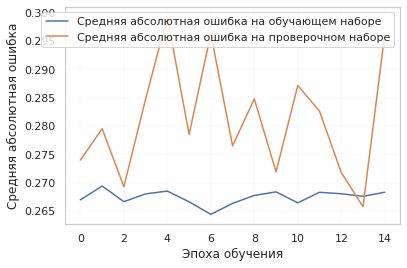

In [137]:
history = model.fit(X_train, 
                    y_trainScaled, 
                    epochs=15, 
                    batch_size=500,
                    validation_split=0.15, 
                    verbose=2)

plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [142]:
y_pred = model.predict(X_test)

# Оценим модель метрикой
get_met = metric(y_test, y_pred)
get_met

11463404.387758316